### 2x Better than Chance within trial but does not generalize well accross trials

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import torch.nn.functional as F
from BcomMEG import *
from MEGDataset_Conv import *
from ConvNet import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# So one option would be to use ResNet as the pretrained and try to fine-tune it. 
# I'm not opposed to this, but it would require messing with the first layer, and
# making sort of arbitrary downscaling of the MEG data. We would have to be clever
# about this. I think I'm just going to try to train my own for right now and see
# how it goes
# resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# print(resnet.conv1)

In [50]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir1 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2']
picks = None

In [ ]:
data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=True)
data.upscale(13)

In [52]:
dataset = MEGDataset_Conv(data, label_map='multi_class_covert')

In [54]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=0.4, 
    random_state=42, 
    stratify=dataset.labels)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch_index, (data, labels) in enumerate(train_loader):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([10, 1, 247, 241])
  Labels shape: torch.Size([10])


In [57]:
device = 'mps'
model = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

n_total_steps = len(train_loader)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
        # print(data)

        outputs = model(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')



Epoch [1 / 50], Step [10/13], Loss: 10.0650
Epoch [2 / 50], Step [10/13], Loss: 6.3177
Epoch [3 / 50], Step [10/13], Loss: 2.6778
Epoch [4 / 50], Step [10/13], Loss: 0.5450
Epoch [5 / 50], Step [10/13], Loss: 0.0068
Epoch [6 / 50], Step [10/13], Loss: 0.0035
Epoch [7 / 50], Step [10/13], Loss: 0.0020
Epoch [8 / 50], Step [10/13], Loss: 0.0004
Epoch [9 / 50], Step [10/13], Loss: 0.0003
Epoch [10 / 50], Step [10/13], Loss: 0.0001
Epoch [11 / 50], Step [10/13], Loss: 0.0001
Epoch [12 / 50], Step [10/13], Loss: 0.0001
Epoch [13 / 50], Step [10/13], Loss: 0.0004
Epoch [14 / 50], Step [10/13], Loss: 0.0003
Epoch [15 / 50], Step [10/13], Loss: 0.0002
Epoch [16 / 50], Step [10/13], Loss: 0.0001
Epoch [17 / 50], Step [10/13], Loss: 0.0001
Epoch [18 / 50], Step [10/13], Loss: 0.0003
Epoch [19 / 50], Step [10/13], Loss: 0.0002
Epoch [20 / 50], Step [10/13], Loss: 0.0004
Epoch [21 / 50], Step [10/13], Loss: 0.0003
Epoch [22 / 50], Step [10/13], Loss: 0.0001
Epoch [23 / 50], Step [10/13], Loss: 0.0

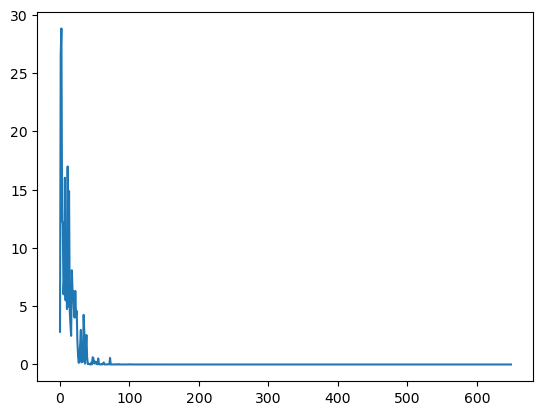

In [58]:
plt.plot(range(len(loss_values)), loss_values)

In [60]:
test_loss_values = []  # To store test loss
test_accuracies = [] 
all_preds = []
all_labels = []
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation for evaluation
    for data, labels in test_loader:
        data, labels = data.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with max logit
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy()) 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)  # Average test loss
accuracy = correct / total  # Test accuracy
test_loss_values.append(test_loss)
test_accuracies.append(accuracy)

print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.4f}')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Loss: {test_loss:.4f}, F1-Score: {f1:.4f}")

Epoch [50/50], Test Loss: 5.1966, Test Accuracy: 7.2289
Test Loss: 5.1966, F1-Score: 0.0601


In [61]:
for i in (np.where(np.array(all_labels) == np.array(all_preds))[0]):
    print (all_preds[i])

12
2
0
7
5
12


In [52]:
1/len(np.unique(dataset.labels)) * 100

5.555555555555555

Then the obvious extension is to train it on more data. Perhaps train it on first 2 trials and have it predict on the last one?

### Accross trials

In [ ]:
data2 = BcomMEG(subjects=['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4'], dir=dir, picks=picks, avoid_reading=True)
data2.upscale(13)
tensor_2 = MEGDataset_Conv(data2, label_map='multi_class_covert')
dataset_2_size = len(tensor_2)
indices = list(range(dataset_2_size))
train_indices, test_indices = train_test_split(
    list(range(len(tensor_2))), 
    test_size=0.2, 
    random_state=42, 
    stratify=tensor_2.labels)

train_dataset_2 = Subset(tensor_2, train_indices)
test_dataset_2 = Subset(tensor_2, test_indices)

In [ ]:
test_labels = [tensor_2.labels[i] for i in test_dataset_2.indices]
plt.hist(test_labels)



In [ ]:
train_labels = [tensor_2.labels[i] for i in train_dataset_2.indices]
plt.hist(train_labels)

In [65]:
train_loader_2 = DataLoader(train_dataset_2, batch_size=10, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=1, shuffle=False)
for batch_index, (data, labels) in enumerate(train_loader_2):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([10, 1, 247, 241])
  Labels shape: torch.Size([10])


In [68]:
device = 'mps'
model_2 = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.00005)
epochs = 30

n_total_steps = len(train_loader_2)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader_2):
        model_2.train()
        data, labels = data.to(device, dtype=torch.float32), labels.to(device,dtype=torch.long)
        # print(data)

        outputs = model_2(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')


Epoch [1 / 30], Step [10/49], Loss: 3.9814
Epoch [1 / 30], Step [20/49], Loss: 3.5633
Epoch [1 / 30], Step [30/49], Loss: 3.5361
Epoch [1 / 30], Step [40/49], Loss: 4.6772
Epoch [2 / 30], Step [10/49], Loss: 1.8335
Epoch [2 / 30], Step [20/49], Loss: 2.3736
Epoch [2 / 30], Step [30/49], Loss: 1.8009
Epoch [2 / 30], Step [40/49], Loss: 2.1431
Epoch [3 / 30], Step [10/49], Loss: 1.7802
Epoch [3 / 30], Step [20/49], Loss: 0.6134
Epoch [3 / 30], Step [30/49], Loss: 1.2379
Epoch [3 / 30], Step [40/49], Loss: 0.6375
Epoch [4 / 30], Step [10/49], Loss: 0.1487
Epoch [4 / 30], Step [20/49], Loss: 0.2172
Epoch [4 / 30], Step [30/49], Loss: 0.2646
Epoch [4 / 30], Step [40/49], Loss: 0.1346
Epoch [5 / 30], Step [10/49], Loss: 0.1083
Epoch [5 / 30], Step [20/49], Loss: 0.0635
Epoch [5 / 30], Step [30/49], Loss: 0.0244
Epoch [5 / 30], Step [40/49], Loss: 0.0531
Epoch [6 / 30], Step [10/49], Loss: 0.0194
Epoch [6 / 30], Step [20/49], Loss: 0.0120
Epoch [6 / 30], Step [30/49], Loss: 0.0196
Epoch [6 / 

In [70]:
test_loss_values = []
test_accuracies = [] 
all_preds = []
all_labels = []
model_2.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader_2:
        # Move both data and labels to device
        data, labels = data.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
        
        # Get predictions
        outputs = model_2(data)
        loss = criterion(outputs, labels)
        
        # Accumulate loss
        test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Save predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate final metrics
    test_loss /= len(test_loader_2)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {100 * accuracy:.2f}%')

# Print detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds))

# Additional diagnostics
print("\nClass distribution in test set:")
from collections import Counter
print(Counter(all_labels))

# Look at some predictions
print("\nSample predictions vs actual:")
for i in range(min(10, len(all_preds))):
    print(f"Predicted: {all_preds[i]}, Actual: {all_labels[i]}")

Test Loss: 4.0537, Accuracy: 8.26%

Confusion Matrix:
[[0 1 0 1 1 3 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 1 0 1 0 1 0 1 0 0 2 0 0 0]
 [0 0 0 0 0 2 0 1 1 0 0 0 0 0 1 1 0 1]
 [0 0 0 3 0 0 2 2 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0]
 [0 0 0 1 0 1 0 0 1 1 2 0 0 1 1 1 0 0]
 [0 0 2 1 0 0 1 2 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 2 0]
 [0 0 0 1 0 2 3 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0]
 [0 1 0 1 0 0 1 0 0 3 0 1 0 0 0 0 1 0]
 [1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 1 2 1 1 0 0 0 0 0 0 0]
 [0 1 0 2 0 1 1 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 2 0 0 2 0 0 1 1 0 0 0 0 0 0 0]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00    

Kfold

In [47]:
import torch
from sklearn.model_selection import KFold

# Set the number of folds
n_folds = 5

# Initialize the cross-validation split
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize lists to store the results
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(tensor_2)):
    print(f'Fold {fold + 1}/{n_folds}')
    # Move the model to the device
    device = torch.device('mps')
    model = ConvNet().to(device=device)

    # Create train and validation dataloaders
    train_loader = DataLoader(dataset=tensor_2, batch_size=4, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    val_loader = DataLoader(dataset=tensor_2, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

    # Training loop
    for epoch in range(20):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f'Epoch [{epoch + 1}/{10}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Append the results for the current fold
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

# Calculate the average results across the folds
avg_train_loss = sum(train_losses) / n_folds
avg_val_loss = sum(val_losses) / n_folds
avg_train_acc = sum(train_accs) / n_folds
avg_val_acc = sum(val_accs) / n_folds

print(f'Average Train Loss: {avg_train_loss:.4f}, Average Train Acc: {avg_train_acc:.2f}%')
print(f'Average Val Loss: {avg_val_loss:.4f}, Average Val Acc: {avg_val_acc:.2f}%')

Fold 1/5
Epoch [1/10], Train Loss: 5.1316, Train Acc: 6.03%, Val Loss: 5.0003, Val Acc: 7.44%
Epoch [2/10], Train Loss: 1.5814, Train Acc: 57.38%, Val Loss: 4.8427, Val Acc: 4.96%
Epoch [3/10], Train Loss: 0.4294, Train Acc: 90.44%, Val Loss: 4.3160, Val Acc: 4.13%
Epoch [4/10], Train Loss: 0.2049, Train Acc: 96.67%, Val Loss: 4.4251, Val Acc: 2.48%
Epoch [5/10], Train Loss: 0.0441, Train Acc: 99.79%, Val Loss: 4.1283, Val Acc: 7.44%
Epoch [6/10], Train Loss: 0.0214, Train Acc: 100.00%, Val Loss: 4.0952, Val Acc: 5.79%
Epoch [7/10], Train Loss: 0.0156, Train Acc: 100.00%, Val Loss: 4.0970, Val Acc: 6.61%
Epoch [8/10], Train Loss: 0.0121, Train Acc: 100.00%, Val Loss: 4.1415, Val Acc: 7.44%
Epoch [9/10], Train Loss: 0.0096, Train Acc: 100.00%, Val Loss: 4.1063, Val Acc: 9.09%
Epoch [10/10], Train Loss: 0.0085, Train Acc: 100.00%, Val Loss: 4.1794, Val Acc: 9.09%
Epoch [11/10], Train Loss: 0.0071, Train Acc: 100.00%, Val Loss: 4.2007, Val Acc: 4.96%
Epoch [12/10], Train Loss: 0.0066, Tra